In [2]:
cd "D:\Jupyter\Cough Classification\few-shot-ho-master"

D:\Jupyter\Cough Classification\few-shot-ho-master


In [3]:
import torch
import torchaudio
import torch.nn as nn
import os
from os import listdir
import torch.nn.functional as F
from protonets.models.encoder.baseUtil import Flatten, get_padding
from collections import OrderedDict
import numpy as np

In [4]:
import os
def cough_path(file):
    label = file.split("_")[0]
#     print(label)
    file_path =os.path.join(os.path.join(path, label), file)
    return file_path, label

def build_mfcc_extractor():
        frame_len = 128/ 1000
        stride = (128/2)/ 1000
        sample_rate = 16000
        mfcc = torchaudio.transforms.MFCC(sample_rate = 16000,
                                        n_mfcc=40,
                                        melkwargs={
                                            'hop_length' : int(stride*sample_rate),
                                            'n_fft' : int(frame_len*sample_rate)})
        return mfcc
    
def load_audio(filepath):
        desired_samples = int(16000*1000/1000)
        sound, _ = torchaudio.load(filepath=filepath,
                                         num_frames=desired_samples)
#         d[out_field] = sound
        return sound

def getData(file):
    file_path, label = cough_path(file)
    sound = load_audio(file_path)
#     print("file: ", sound)
    mfcc = build_mfcc_extractor()
#     x = mfcc(sound).reshape(1,51,40)
    features = mfcc(sound)[0]
    features = features.T # f x t -> t x f
    x = torch.unsqueeze(features,0)
#     print(x.shape)
    return x, label

def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
#     print(x.shape) #1, 3, 48
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
#     print(n, m, d)
#     print("y_Shape: ", y.shape) #3, 1, 48
#     print(y.size(1))
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
#     print(x)
#     print("x_u: ", x.shape)
    y = y.unsqueeze(0).expand(n, m, d)
#     print(y)
#     print("y_u: ", y.shape)
    return torch.pow(x - y, 2).sum(2)

In [5]:
model_path = "D:\\HoangNgan\\DoAn\\2022-03-03 07_56_11\\best_model.pt"
model = torch.load(model_path)

In [6]:
model = torch.load(model_path)

In [7]:

# query = request.FILES.get('query', None).name
# s1 = request.FILES.get('s1', None).name
# audio.append(s1)
# s2 = request.FILES.get('s2', None).name
# audio.append(s2)
# s3 = request.FILES.get('s3', None).name
# audio.append(s3)
# s4 = request.FILES.get('s4', None).name
# audio.append(s4)

def get_support(audio):
    support = {}
    labels = []
    for file in audio:
        label = file.split("_")[0]
        if label not in labels:
            labels.append(label)
        if label not in support:
            support[label] = []
        for same in audio:
            if label == same.split("_")[0]:
                if same not in support[label]:
                    support[label].append(same)
    return support, labels

def predictLabel(query, support, labels):
    x, label = getData(query)
    xq_emb = model.encoder(x.reshape(1, 1, 16, 40))
#     print("xq_emb: ", xq_emb.shape)
    su_label = []
    su_pro = []
    for key, value in support.items():
        su_label.append(key)
        tmp = []
        check = 0
        count = 0
        for i in value:
            x, label_i = getData(i)
            feature = x.reshape(1, 1, 16, 40)
            emb = model.encoder.forward(feature).squeeze()
#             print("y_emb:", emb.shape)
            check += emb
            tmp.append(emb.detach().numpy())
            count += 1
#         print("check:", (check/3).shape)
#         print("check:", check/count, count)
        tmp = np.array(tmp)
        pro = (tmp).mean(0)
#         print("pro: ", pro)
        su_pro.append(pro)
    dists = euclidean_dist(xq_emb.reshape(1, 48), torch.tensor(su_pro))
    n_class, n_query = torch.tensor(su_pro).shape[0], 1
    log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)
#     print("log_py: ", log_p_y)
    g, y_hat = log_p_y.max(0)
#     print("log_py: ", log_p_y.max(0))
#     print("g, y_hat: ", g, y_hat)
    pred = labels[y_hat.squeeze()]
    return pred, label

In [11]:
path = "D:\\HoangNgan\\ThucTap\\Cough_data_Tuan1\\mono"
label_list = []
label_dict = {}
for i in listdir(path):
    if ".txt" not in i and "aug" not in i and 'Copy' not in i:
        label_list.append(i)
        label_dict[str(i)] = len(listdir(os.path.join(path, i)))
        print(str(i) + ": ", len(listdir(os.path.join(path, i))))

barkingcough:  1040
chestyandwetcough:  1663
coughingupcrapagain:  884
dryafternooncough:  1040
gaggywetcough:  1117
heavycoldandsorethroatcoughing:  416
nightwetcough:  1300
springallergycoughing:  884
unknown:  1557
whoopingcough:  40


In [9]:
label_dict[label_list[1]]

1663

In [9]:
print(label_list)

['barkingcough', 'chestyandwetcough', 'coughingupcrapagain', 'dryafternooncough', 'gaggywetcough', 'heavycoldandsorethroatcoughing', 'nightwetcough', 'springallergycoughing', 'unknown', 'whoopingcough']


In [213]:
audio = []
query = "whoopingcough_30.wav"
# audio.append(query)
s1 = "unknown_1.wav"
audio.append(s1)
s2 = "unknown_1.wav"
audio.append(s2)
s3 = "unknown_11.wav"
audio.append(s3)
s4 = "unknown_21.wav"
audio.append(s4)

In [214]:
support, labels = get_support(audio)
print(support, labels)
print(predictLabel(query, support, labels))

{'unknown': ['unknown_1.wav', 'unknown_11.wav', 'unknown_21.wav']} ['unknown']
xq_emb:  torch.Size([1, 48])
y_emb: torch.Size([48])
y_emb: torch.Size([48])
y_emb: torch.Size([48])
torch.Size([1, 48])
1 1 48
y_Shape:  torch.Size([1, 48])
log_py:  tensor([[[0.]]], grad_fn=<ViewBackward>)
log_py:  torch.return_types.max(
values=tensor([[0.]], grad_fn=<MaxBackward0>),
indices=tensor([[0]]))
g, y_hat:  tensor([[0.]], grad_fn=<MaxBackward0>) tensor([[0]])
('unknown', 'whoopingcough')


In [10]:
#setup dataset
#2way-2shot
#train
train_label = label_list[:8]
test_label = label_list[8:]

In [11]:
print(test_label)

['unknown', 'whoopingcough']


In [12]:
#label1:
import random
def set_support_label(index_label):
    index_list = list(range(len(train_label)))
#     print(index_label)
    index_list.remove(index_label)
#     print(index_list)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    label1 = train_label[index_label]
    label2 = train_label[ix]
    return index_label, ix, label1, label2


def set_support_label2(index_label):
    index_list = list(range(len(test_label)))
#     print(index_label)
    index_list.remove(index_label)
#     print(index_list)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    label1 = test_label[index_label]
    label2 = test_label[ix]
    return index_label, ix, label1, label2

def set_support_data(label, index_audio):
#     if index_label == 0:
#         index_label = 8
#     else:
#         index_label = 9
    index_list = list(range(1, label_dict[label]+1))
#     index = random.choice(index_list)
    index_list.remove(index_audio)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    
    new_index_list.remove(ix)
    temp_list = new_index_list
    ixx = random.choice(temp_list)
    audio1 = label+'_'+str(index_audio)+'.wav'
    audio2 = label+'_'+str(ix)+'.wav'
    audio3 = label+'_'+str(ixx)+'.wav'
    return audio1, audio2, audio3

print(set_support_label(0))
# print(list(range(len(train_label))))
print(set_support_data("whoopingcough", 32))

(0, 5, 'barkingcough', 'heavycoldandsorethroatcoughing')
('whoopingcough_32.wav', 'whoopingcough_29.wav', 'whoopingcough_23.wav')


In [232]:
query1, support1, labels1 = None, None, None

In [13]:
predict_label = []
real_label = []
i = 0
            
for i_label in train_label: # lap qua moi nhan
    index_label, ix_label, label1, label2 = set_support_label(i)
    for i_data in range(0, label_dict[label1]): #lap qua moi data cua 1 nhan
        i_data += 1
        try:
            audio1, audio2, audio3 = set_support_data(label1, i_data)
            ix_data = random.choice(list(range(1, label_dict[label2]+1)))
            audio4, audio5, audio6 = set_support_data(label2, ix_data)
            audio = [audio2, audio3, audio5, audio6]
        except:
            print(index_label, i_data)
            print(ix_label, i_data)
#         print(audio)
#         audio.append()
        query1 = audio1
#         print(audio1, audio2, audio3, audio5, audio6)
        support1, labels1 = get_support(audio)
#         print(labels1)
#         print(support1, labels1)
        pred, label = predictLabel(query1, support1, labels1)
#         print(pred, label)
        predict_label.append(pred)
        real_label.append(label)
#         break
#         print(predict_label(query1, support1, labels1))

    i += 1
#     break

C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


In [14]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
print(len(predict_label))
print(len(real_label))

8344
8344


In [16]:
count = 0
for i in range(len(predict_label)):
    if predict_label[i] != real_label[i]:
        count += 1
print(count)

1363


In [19]:
y_pred = predict_label
y_true = real_label

In [20]:
cm_train = confusion_matrix(y_true, y_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[ 928    0    0    0  112    0    0    0]
 [   0 1633    0   30    0    0    0    0]
 [   0    0  797    0   87    0    0    0]
 [   0    0    0  849    0  191    0    0]
 [   0    0  632    0  485    0    0    0]
 [   0   61    0    0    0  355    0    0]
 [   0    0    0    0    0   17 1283    0]
 [   0    0    0    0    0  233    0  651]]


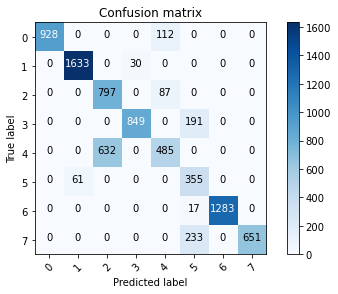

In [21]:
plot_confusion_matrix(cm_train, classes=['0','1', '2', '3', '4', '5', '6', '7'],
                      title='Confusion matrix')

In [31]:
result = {'barkingcough': 951/1040, 'chestyandwetcough': 1630/1663, 
          'coughingupcrapagain': 870/884, 'dryafternooncough': 818/1040, 
          'gaggywetcough': 478/1117, 'heavycoldandsorethroatcoughing': 355/416, 
          'nightwetcough': 892/1300, 'springallergycoughing': 616/884, 
          'unknown': 1289/1557, 'whoopingcough': 31/33}
print(result)

{'barkingcough': 0.9144230769230769, 'chestyandwetcough': 0.9801563439567047, 'coughingupcrapagain': 0.9841628959276018, 'dryafternooncough': 0.7865384615384615, 'gaggywetcough': 0.4279319606087735, 'heavycoldandsorethroatcoughing': 0.8533653846153846, 'nightwetcough': 0.6861538461538461, 'springallergycoughing': 0.6968325791855203, 'unknown': 0.827874116891458, 'whoopingcough': 0.9393939393939394}


In [23]:
val_predict_label = []
val_real_label = []
i = 0
for i_label in test_label: # lap qua moi nhan
    index_label, ix_label, label1, label2 = set_support_label2(i)
    
    for i_data in range(0, label_dict[label1]): #lap qua moi data cua 1 nhan
        i_data += 1
        try:
            audio1, audio2, audio3 = set_support_data(label1, i_data)
            ix_data = random.choice(list(range(1, label_dict[label2]+1)))
            audio4, audio5, audio6 = set_support_data(label2, ix_data)
            audio = [audio2, audio3, audio5, audio6]
        except:
            print(index_label, i_data)
            print(ix_label, i_data)
#         print(audio)
#         audio.append()
        query1 = audio1
#         print(audio1, audio2, audio3, audio5, audio6)
        support1, labels1 = get_support(audio)
#         print(labels1)
#         print(support1, labels1)
        pred, label = predictLabel(query1, support1, labels1)
#         print(pred, label)
        val_predict_label.append(pred)
        val_real_label.append(label)
#         break
#         print(predict_label(query1, support1, labels1))

    i += 1

C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


In [27]:
count = 0
for i in range(len(val_predict_label)):
    if val_predict_label[i] != val_real_label[i]:
        count += 1
print(count)
print(len(val_predict_label))

270
1590


In [28]:
val_true, val_pred = val_real_label ,val_predict_label

In [29]:
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[1289  268]
 [   2   31]]


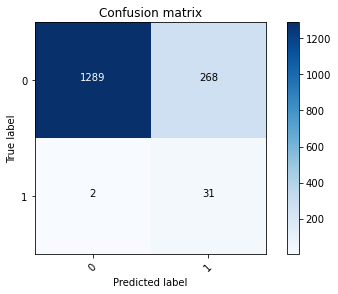

In [30]:
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

# Version 1

In [277]:
print(len(predict_label))
print(len(real_label))

8336
8336


In [279]:
count = 0
for i in range(len(predict_label)):
    if predict_label[i] != real_label[i]:
        count += 1
print(count)

1338


In [282]:
y_pred = predict_label
y_true = real_label

In [ ]:
for i in range(1, label_dict[label_list[9]]):
    print(i)

In [268]:
range(1, label_dict[label_list[9]])

range(1, 33)

In [284]:
cm_train = confusion_matrix(y_true, y_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[ 740    0    0  299    0    0    0    0]
 [   0 1231    0    0    0    0  431    0]
 [  14    0  869    0    0    0    0    0]
 [   0    0   50  989    0    0    0    0]
 [   0    0    0  236  880    0    0    0]
 [   0    0    0    0   77  338    0    0]
 [   0    0    0    0  158    0 1141    0]
 [   0   73    0    0    0    0    0  810]]


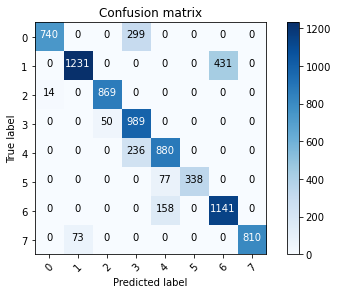

In [286]:
plot_confusion_matrix(cm_train, classes=['0','1', '2', '3', '4', '5', '6', '7'],
                      title='Confusion matrix')

In [ ]:
[]

In [288]:
print(label_dict)

{'barkingcough': 1040, 'chestyandwetcough': 1663, 'coughingupcrapagain': 884, 'dryafternooncough': 1040, 'gaggywetcough': 1117, 'heavycoldandsorethroatcoughing': 416, 'nightwetcough': 1300, 'springallergycoughing': 884, 'unknown': 1557, 'whoopingcough': 33}


In [289]:
m = 740/1040  + 1231/1663 + 869/884 + 989/1040 + 880/1117 + 338/416 + 1141/1300 + 810/884
print(m/8)


0.8475083259197043


In [2]:
result = {'barkingcough': 740/1040, 'chestyandwetcough': 1231/1663, 
          'coughingupcrapagain': 869/884, 'dryafternooncough': 989/1040, 
          'gaggywetcough': 880/1117, 'heavycoldandsorethroatcoughing': 338/416, 
          'nightwetcough': 1141/1300, 'springallergycoughing': 810/884, 
          'unknown': 1294/1557, 'whoopingcough': 30/33}
print(result)

{'barkingcough': 0.7115384615384616, 'chestyandwetcough': 0.7402285027059531, 'coughingupcrapagain': 0.9830316742081447, 'dryafternooncough': 0.9509615384615384, 'gaggywetcough': 0.7878245299910475, 'heavycoldandsorethroatcoughing': 0.8125, 'nightwetcough': 0.8776923076923077, 'springallergycoughing': 0.916289592760181, 'unknown': 0.8310854206807964, 'whoopingcough': 0.9090909090909091}


In [1]:
result = {'barkingcough': 740/1039, 'chestyandwetcough': 1231/1662, 
          'coughingupcrapagain': 869/883, 'dryafternooncough': 989/1039, 
          'gaggywetcough': 880/1116, 'heavycoldandsorethroatcoughing': 338/415, 
          'nightwetcough': 1141/1299, 'springallergycoughing': 810/883, 
          'unknown': 1294/1557, 'whoopingcough': 30/33}
print(result)

{'barkingcough': 0.7122232916265641, 'chestyandwetcough': 0.7406738868832732, 'coughingupcrapagain': 0.984144960362401, 'dryafternooncough': 0.9518768046198267, 'gaggywetcough': 0.7885304659498208, 'heavycoldandsorethroatcoughing': 0.8144578313253013, 'nightwetcough': 0.8783679753656659, 'springallergycoughing': 0.9173272933182333, 'unknown': 0.8310854206807964, 'whoopingcough': 0.9090909090909091}


In [3]:
s = (0.831 + 0.909)/2
print(s)

0.87


In [303]:
val_predict_label = []
val_real_label = []
i = 0
for i_label in test_label: # lap qua moi nhan
    index_label, ix_label, label1, label2 = set_support_label2(i)
    
    for i_data in range(0, label_dict[label1]): #lap qua moi data cua 1 nhan
        i_data += 1
        try:
            audio1, audio2, audio3 = set_support_data(label1, i_data)
            ix_data = random.choice(list(range(1, label_dict[label2]+1)))
            audio4, audio5, audio6 = set_support_data(label2, ix_data)
            audio = [audio2, audio3, audio5, audio6]
        except:
            print(index_label, i_data)
            print(ix_label, i_data)
#         print(audio)
#         audio.append()
        query1 = audio1
#         print(audio1, audio2, audio3, audio5, audio6)
        support1, labels1 = get_support(audio)
#         print(labels1)
#         print(support1, labels1)
        pred, label = predictLabel(query1, support1, labels1)
#         print(pred, label)
        val_predict_label.append(pred)
        val_real_label.append(label)
#         break
#         print(predict_label(query1, support1, labels1))

    i += 1
#     break

In [307]:
count = 0
for i in range(len(val_predict_label)):
    if i 
    if val_predict_label[i] != val_real_label[i]:
        count += 1
print(count)
print(len(val_predict_label))

266
1590


In [308]:
val_true, val_pred = val_real_label ,val_predict_label

In [309]:
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[1294  263]
 [   3   30]]


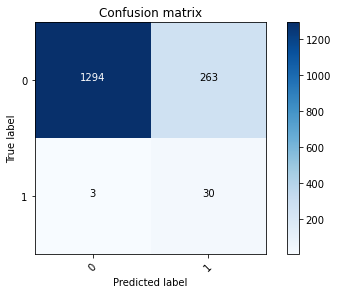

In [310]:
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [ ]:
1294/1557 = 0.831085 # unknown
30/33 = 0.90909091

In [ ]:
load
start====
predict
end====


# Ver 3 (same sample)

In [ ]:
val_predict_label = []
val_real_label = []
i = 0
for i_label in test_label: # lap qua moi nhan
    index_label, ix_label, label1, label2 = set_support_label2(i)
    
#     for i_data in range(0, label_dict[label1]): #lap qua moi data cua 1 nhan
    for i_data in range(0, 33):
        i_data += 1
        try:
            audio1, audio2, audio3 = set_support_data(label1, i_data)
            ix_data = random.choice(list(range(1, label_dict[label2]+1)))
            audio4, audio5, audio6 = set_support_data(label2, ix_data)
            audio = [audio2, audio3, audio5, audio6]
        except:
            print(index_label, i_data)
            print(ix_label, i_data)
#         print(audio)
#         audio.append()
        query1 = audio1
#         print(audio1, audio2, audio3, audio5, audio6)
        support1, labels1 = get_support(audio)
#         print(labels1)
#         print(support1, labels1)
        pred, label = predictLabel(query1, support1, labels1)
#         print(pred, label)
        val_predict_label.append(pred)
        val_real_label.append(label)
#         break
#         print(predict_label(query1, support1, labels1))

    i += 1

In [ ]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [ ]:
Confusion matrix: 
 [[18 15]
 [ 3 30]]